In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from sklearn.metrics import silhouette_score, silhouette_samples

from matplotlib import style
style.use('ggplot')
style.use('seaborn-ticks')

В прошлых домашках датасет уже был обработан. Импортируем его сразу из csv, также импортируем изначальный датасет.

In [2]:
df_raw = pd.read_csv('bank.csv', sep = ';')
df = pd.read_csv('data_scaled.csv')

LOFом ранее были убраны выбросы, и здесь уберем их в обоих датасетах

In [269]:
data_types = df_raw.dtypes
int_cols = [df_raw.columns[i] for i in range(df_raw.shape[1]) if data_types[i] == 'int64']
float_cols = [df_raw.columns[i] for i in range(df_raw.shape[1]) if data_types[i] == 'float64']
cat_cols = [df_raw.columns[i] for i in range(df_raw.shape[1]) if data_types[i] == 'O']
y = cat_cols.pop(-1)

from sklearn.neighbors import LocalOutlierFactor

scaler = StandardScaler()
df_out = scaler.fit_transform(df_raw[[*int_cols, *float_cols]])

lof = LocalOutlierFactor(n_neighbors= 20)
outliers_data = lof.fit_predict(df_out)
mask = outliers_data != -1

df_raw = df_raw[mask]
df = df[mask]

## K-means

In [66]:
models = []
clusters_num = range(2, 9)
for i in range(2, 9):
    model = KMeans(n_clusters = i, random_state = 54)
    model.fit_predict(df)
    models.append(model)

In [71]:
inertia = [m.inertia_ for m in models]
silhouette = [silhouette_score(df, m.labels_) for m in models] # как-то долго считается, если не понижать размерность

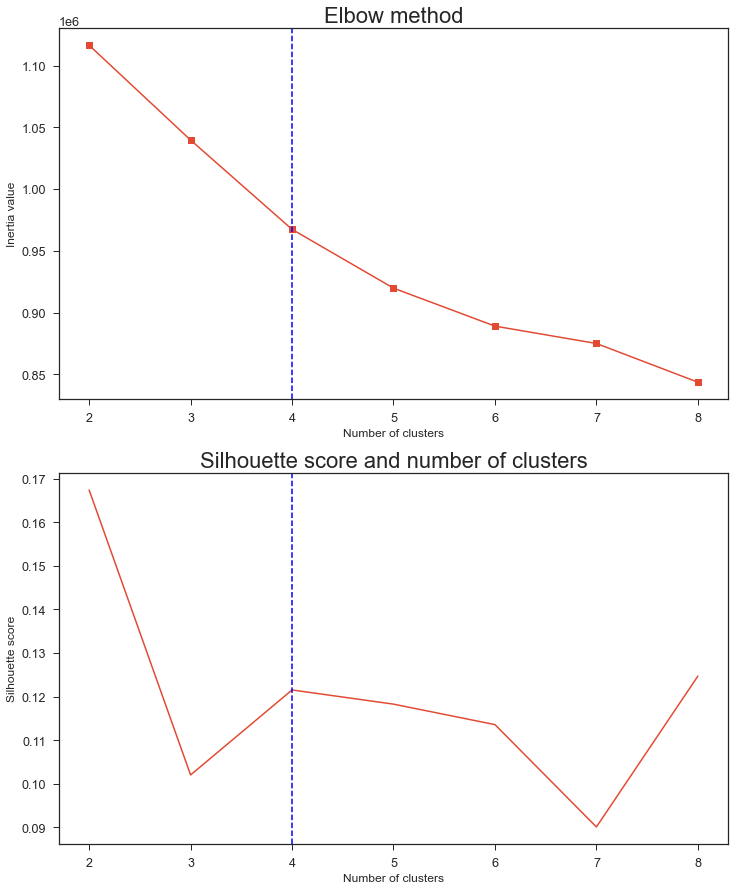

In [73]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 15))
ax1.plot(clusters_num, inertia, marker='s')
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Inertia value')
ax1.set_title('Elbow method', size = 22);
ax1.axvline(x = 4, color = 'blue', linestyle = '--');
ax1.set_xticks(clusters_num);

ax2.plot(clusters_num, silhouette)
ax2.set_xlabel('Number of clusters')
ax2.set_ylabel('Silhouette score')
ax2.set_title('Silhouette score and number of clusters', size = 22);
ax2.axvline(x = 4, color = 'blue', linestyle = '--');
ax2.set_xticks(clusters_num);

Кажется, что число кластеров равно 4-м оптимальное по каменистой осыпи. Но значение силуэтов очень маленькое в целом. Попробуем все-таки понизить разиерность и попробовать еще

For n_clusters = 2 The average silhouette_score is : 0.16738796004930984
For n_clusters = 3 The average silhouette_score is : 0.10203473442048427
For n_clusters = 4 The average silhouette_score is : 0.12152750344320283


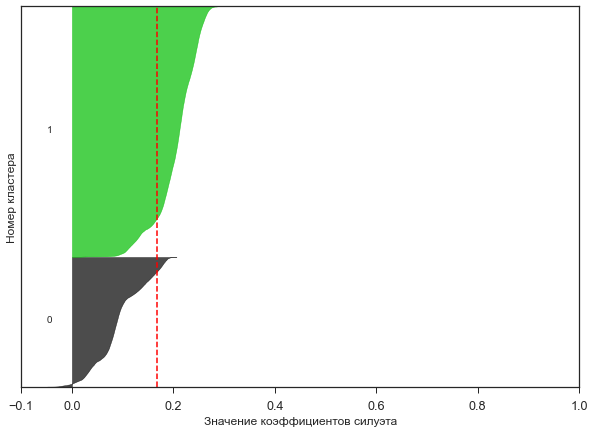

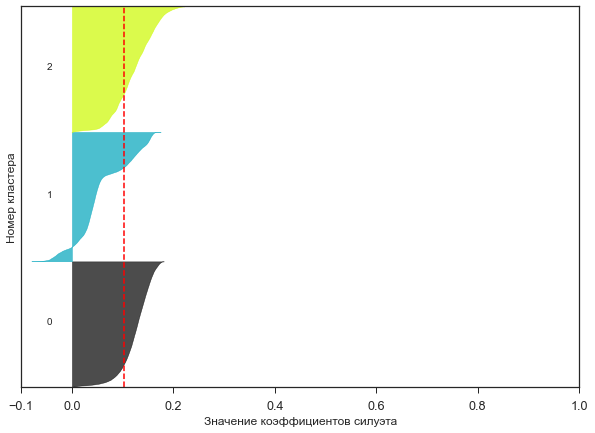

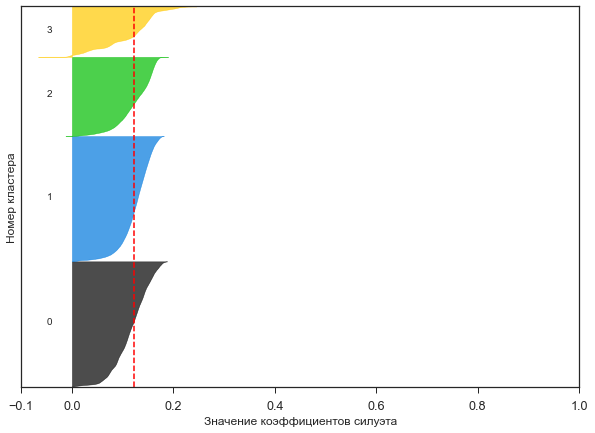

In [78]:
# график силуэтов

import matplotlib.cm as cm
y = model.labels_
range_n_clusters = [2, 3, 4]

for n_clusters in range_n_clusters:
    fig, (ax1) = plt.subplots(1)
    fig.set_size_inches(10, 7)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(df) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(df)

    silhouette_avg = silhouette_score(df, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    sample_silhouette_values = silhouette_samples(df, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    ax1.set_xlabel("Значение коэффициентов силуэта")
    ax1.set_ylabel("Номер кластера")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])  

Мда... Понизим размерность. В целом PCA на этом датасете убирает только 35% признаков, если сохранять 95% дисперсии. Это по крайней мере должно ускорить расчеты по моделям. Скоро будет t-SNE, может он лучше работает

In [88]:
pca = PCA(n_components = 0.95)
df_pca = pca.fit_transform(df)

In [89]:
models2 = []
clusters_num = range(2, 9)
for i in range(2, 9):
    model = KMeans(n_clusters = i, random_state = 54)
    model.fit_predict(df_pca)
    models2.append(model)

In [90]:
inertia2 = [m.inertia_ for m in models2]
silhouette2 = [silhouette_score(df, m.labels_) for m in models2] # как-то долго считается, если не понижать размерность

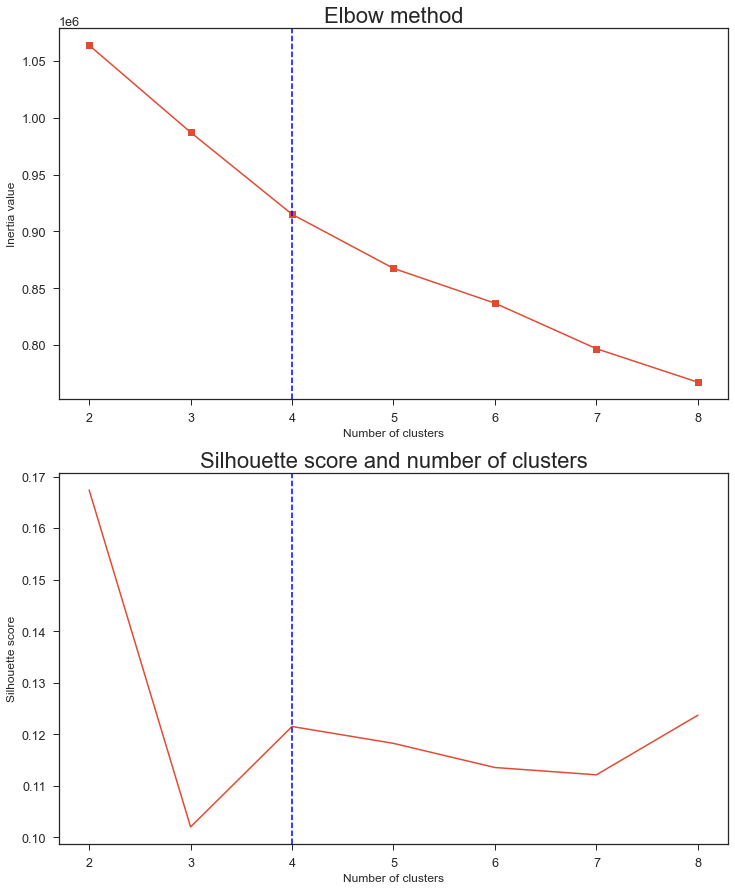

In [92]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 15))
ax1.plot(clusters_num, inertia2, marker='s')
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Inertia value')
ax1.set_title('Elbow method', size = 22);
ax1.axvline(x = 4, color = 'blue', linestyle = '--');
ax1.set_xticks(clusters_num);

ax2.plot(clusters_num, silhouette2)
ax2.set_xlabel('Number of clusters')
ax2.set_ylabel('Silhouette score')
ax2.set_title('Silhouette score and number of clusters', size = 22);
ax2.axvline(x = 4, color = 'blue', linestyle = '--');
ax2.set_xticks(clusters_num);

Ладно, а если взять только числовые?

In [111]:
df_num = df_raw[[*int_cols, *float_cols]]
df_num.drop('pdays', axis = 1)
df_num = scaler.fit_transform(df_num)

In [112]:
models3 = []
clusters_num = range(2, 9)
for i in range(2, 9):
    model = KMeans(n_clusters = i, random_state = 54)
    model.fit_predict(df_num)
    models3.append(model)

In [113]:
inertia3 = [m.inertia_ for m in models3]
silhouette3 = [silhouette_score(df_num, m.labels_) for m in models3] 

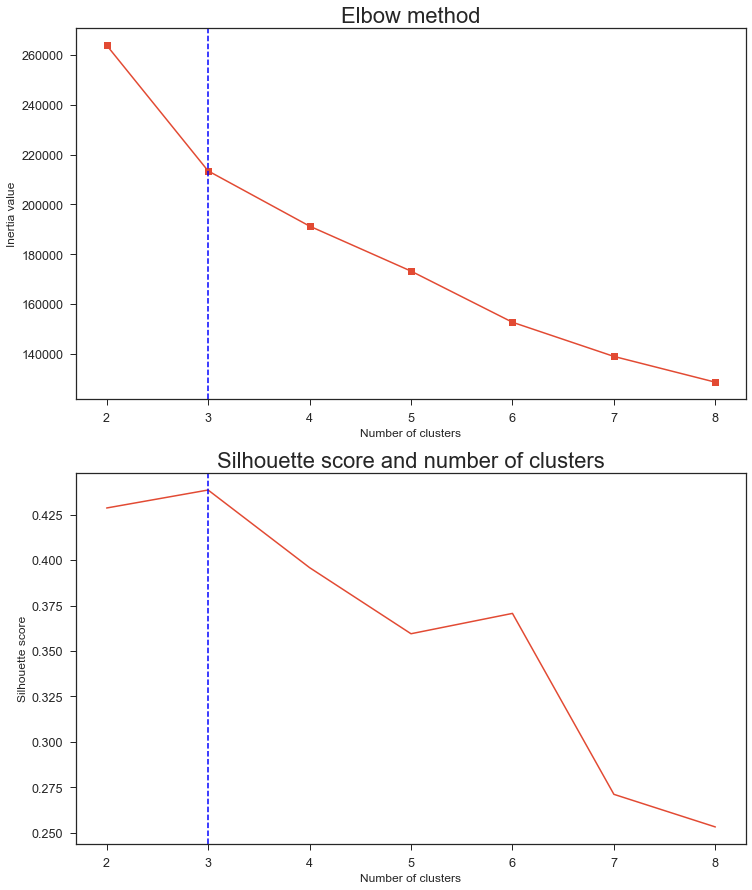

In [115]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 15))
ax1.plot(clusters_num, inertia3, marker='s')
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Inertia value')
ax1.set_title('Elbow method', size = 22);
ax1.axvline(x = 3, color = 'blue', linestyle = '--');
ax1.set_xticks(clusters_num);

ax2.plot(clusters_num, silhouette3)
ax2.set_xlabel('Number of clusters')
ax2.set_ylabel('Silhouette score')
ax2.set_title('Silhouette score and number of clusters', size = 22);
ax2.axvline(x = 3, color = 'blue', linestyle = '--');
ax2.set_xticks(clusters_num);

Если смотреть только на числовые фичи, силуэт уже поприличнее, а оптимальное число кластеров - 6 либо 3.

## Иерархическая кластеризация

У иерархической кластеризации сложность $O(n^3)$ (но может там зашито что-то пооптимальнее), поэтому будем кластеризовать только по числовым данным, иначе не дождемся. Да и вообще, с нечисловыми признаками все как-то криво

In [118]:
alink = linkage(df_num, 'ward','euclidean')
plt.figure(figsize=(12, 6))
dn = dendrogram(link, color_threshold = 10, no_labels = True);

MemoryError: Unable to allocate 6.18 GiB for an array with shape (829486815,) and data type float64

Памяти не хватает

In [121]:
df_num_pca = pca.fit_transform(df_num)

In [123]:
link = linkage(df_num_pca, 'ward','euclidean')

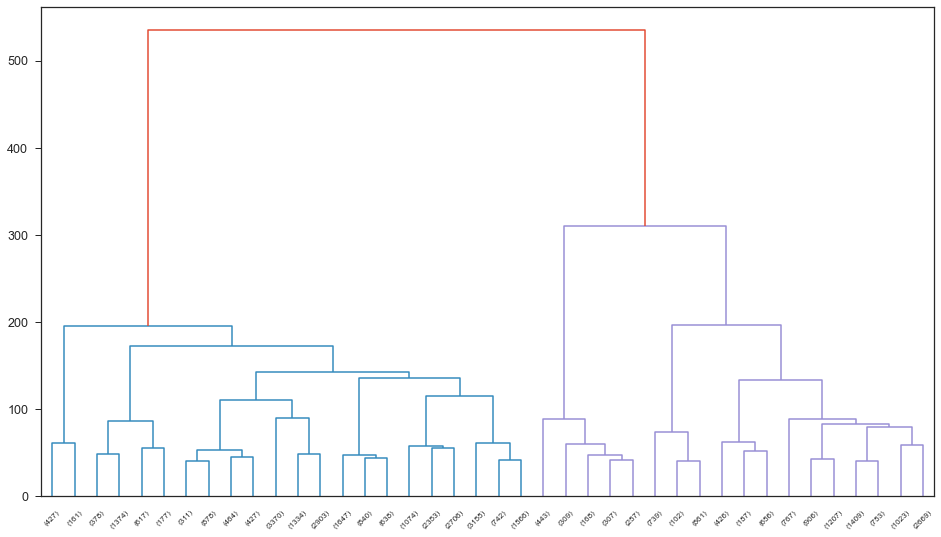

In [132]:
plt.figure(figsize=(16, 9))
dn = dendrogram(link,truncate_mode='lastp', p = 40);

Памяти хватило только на датасет с числовыми признаками и пониженной размерностью. Получилось не очень наглядно, расстояние между кластерами небольшое, из-за этого они как бы вложены, их тяжело отделить.

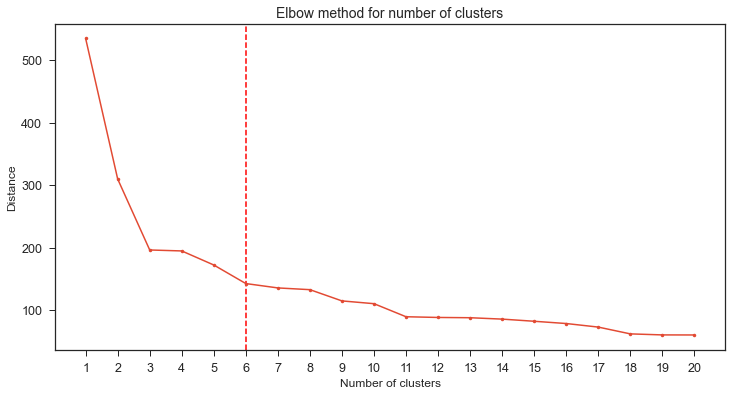

In [141]:
max_n = 20
xticks = 1 + np.arange(max_n)

fig, ax = plt.subplots(figsize = (12, 6))
plt.title('Elbow method for number of clusters', size=14)
plt.xlabel('Number of clusters')
plt.ylabel('Distance')
plt.xticks(xticks)
plt.axvline(x=6, color='red', linestyle='--')
plt.plot(xticks, link[-1:-max_n - 1:-1, 2], marker='.')
plt.show()

6 кластеров, наверное. Но по дендрограмме непонятно какие конкретно

# DBSCAN

Попробуем найти такие гиперпараметры, чтобы попасть в разумное число кластеров (3 либо 6)

In [199]:
dbscan = DBSCAN(eps=1, min_samples=500, leaf_size=30)
y_dbscan = dbscan.fit_predict(df_num)

In [200]:
y = pd.Series(y_dbscan)
y.value_counts()

-1    9740
 1    9506
 0    7183
 4    5388
 2    4543
 3    2553
 5    1818
dtype: int64

Если бы был компьютер помощнее, можно было бы перебрать гиперпараметры. Но в целом-то датасет скорее для задачи классификации, а не кластеризации

# Интерпретация

In [266]:
df_raw['cluster'] = y

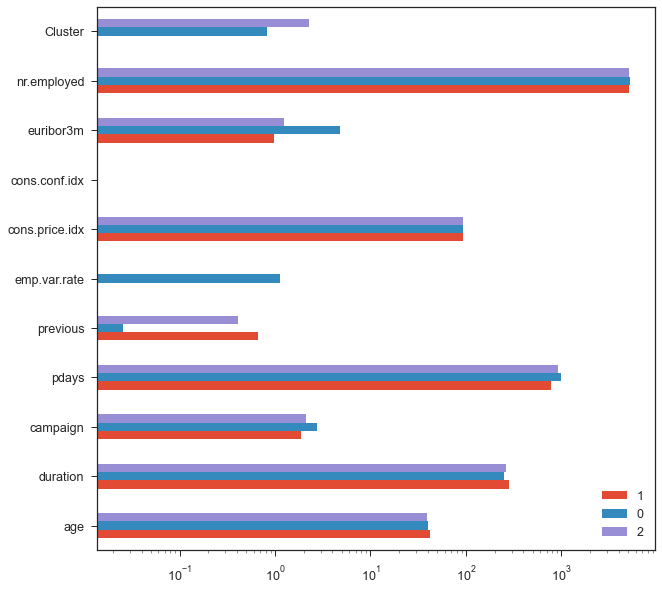

In [267]:
gr = df_raw.groupby('cluster').mean()
gr.index = y.unique()
gr.T.plot.barh(figsize = (10, 10), log = True);

In [234]:
gr

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
Cluster,,,,,,,,,,
-1.0,41.107323,257.847881,2.359736,882.929920,0.376731,-1.070699,93.302165,-38.634421,2.451954,5113.416376
0.0,40.362038,263.751012,2.443405,999.000000,0.000000,1.100000,93.994000,-36.400000,4.857609,5191.000000
1.0,39.301813,259.175311,3.143264,999.000000,0.000000,1.399399,94.132431,-42.334820,4.949552,5228.025690
2.0,41.280671,227.651368,2.798764,999.000000,0.000000,1.400000,93.448393,-36.161165,4.964930,5228.100000
3.0,40.364654,242.765694,1.827269,989.453019,0.201120,-0.098800,93.210477,-41.967773,4.131076,5195.825830
4.0,38.238871,260.960977,2.249668,976.254973,0.308581,-1.767475,92.953439,-46.507539,1.393323,5100.950104
5.0,37.874095,261.208357,2.208357,979.655153,0.335376,-1.800000,92.935201,-46.480836,1.331994,5099.100000


Вообще непонятно по какому принципу все кластеризовалось. Значимые различия есть только в индексах, которые, собственно говоря, не особо-то влияют на отдельного клиента. Например, euribor3m - это Европейская межбанковская ставка предложения, там есть различия в средних по кластерам, только вообще сомнительно, что это как-то относится к банковской компании конкретного банка. 

In [239]:
gr = df_raw.groupby('cluster').agg(lambda x:x.value_counts().index[0])

In [240]:
gr

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
Cluster,,,,,,,,,,,,,,,,,,,,,
-1.0,31,admin.,married,university.degree,no,yes,no,cellular,may,tue,...,1,999,0,nonexistent,1.4,92.893,-46.2,4.962,5228.1,no
0.0,36,blue-collar,married,high.school,no,no,no,telephone,may,tue,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1.0,35,blue-collar,married,high.school,no,no,no,cellular,jul,mon,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
2.0,31,admin.,married,university.degree,no,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.964,5228.1,no
3.0,31,admin.,married,university.degree,no,yes,no,cellular,nov,thu,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.076,5195.8,no
4.0,34,blue-collar,married,high.school,no,yes,no,cellular,may,mon,...,1,999,0,nonexistent,-1.8,92.893,-46.2,1.405,5099.1,no
5.0,34,blue-collar,married,high.school,no,yes,no,cellular,may,thu,...,1,999,0,nonexistent,-1.8,92.893,-46.2,1.405,5099.1,no


Моды нечисловых признаков не отделились сами по себе

Посмотрим что дал K-Means на 3 кластера

In [270]:
y = pd.Series(models3[1].labels_)
df_raw['cluster'] = y

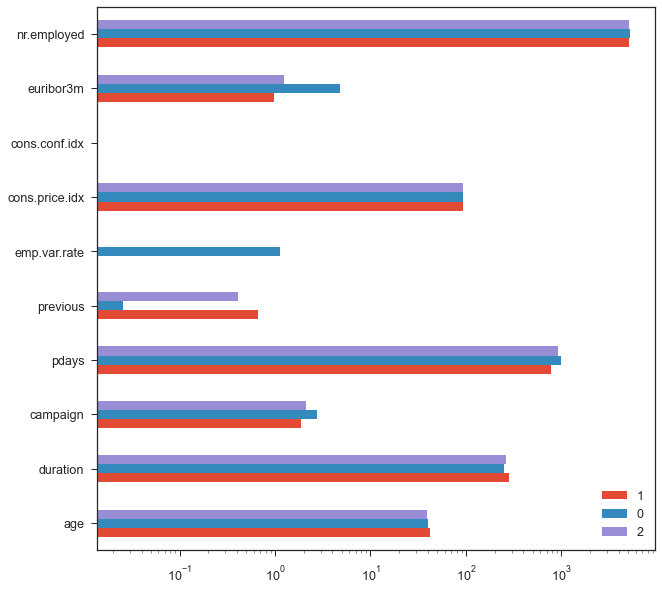

In [271]:
gr = df_raw.groupby('cluster').mean()
gr.index = y.unique()
gr.T.plot.barh(figsize = (10, 10), log = True);

In [264]:
gr

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,Cluster
1,42.319832,280.727654,1.856145,779.914106,0.666899,-2.253841,93.175343,-36.869623,0.968897,5036.190293,-1.000000
0,40.196109,252.175451,2.785860,997.874407,0.025403,1.125896,93.847931,-39.441390,4.822718,5213.538401,0.815351
2,39.252531,260.067103,2.087784,916.933508,0.407853,-2.018613,92.952722,-43.196780,1.237968,5082.426850,2.243019


Опять видны отличия по экономическим индексам.

In [274]:
df_raw.groupby('cluster').agg(lambda x:x.value_counts().index[0])

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
cluster,,,,,,,,,,,,,,,,,,,,,
0.0,35,admin.,married,university.degree,no,yes,no,cellular,may,mon,...,1,999,0,nonexistent,-1.8,92.893,-46.2,0.714,5017.5,no
1.0,31,admin.,married,university.degree,no,yes,no,cellular,may,wed,...,1,999,0,nonexistent,1.4,93.994,-36.4,4.857,5228.1,no
2.0,34,admin.,married,university.degree,no,yes,no,cellular,may,mon,...,1,999,0,nonexistent,-1.8,92.893,-46.2,1.405,5099.1,no


По нечисловым признакам ничего не отделилось. В данном случае кластеризация была только по числам

Посмотрим на разбиение по кластерам, когда мы учитывали нечисловые признаки

In [284]:
y = pd.Series(models[2].labels_)
df_raw['cluster'] = y

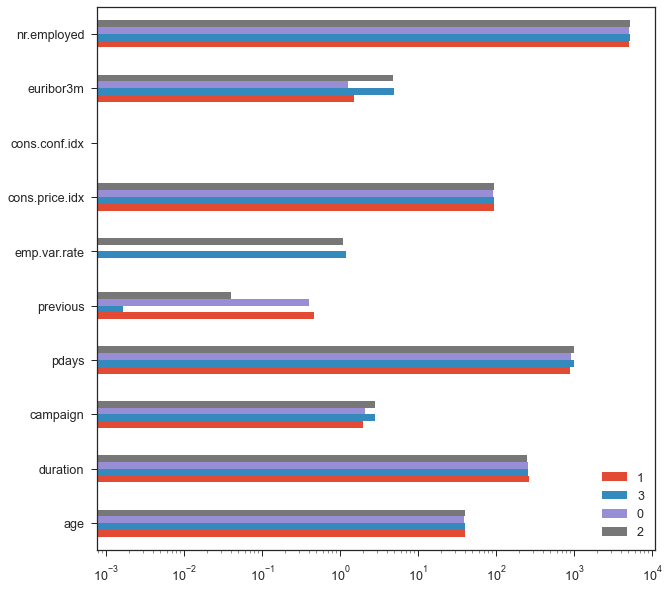

In [285]:
gr = df_raw.groupby('cluster').mean()
gr.index = y.unique()
gr.T.plot.barh(figsize = (10, 10), log = True);

In [286]:
gr

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
1,40.142992,266.884434,1.972007,885.388311,0.469453,-1.846662,93.049467,-41.210441,1.496468,5081.966257
3,40.303153,254.497161,2.838264,999.000000,0.001644,1.212909,94.127617,-38.659398,4.884804,5206.347901
0,39.340876,257.901016,2.094143,919.193974,0.396539,-2.016203,92.949731,-43.273487,1.256423,5083.754247
2,40.057066,250.315510,2.784842,997.137497,0.040740,1.099056,93.599154,-40.100442,4.794767,5221.619681


In [288]:
df_raw.groupby('cluster').agg(lambda x:x.value_counts().index[0])

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
cluster,,,,,,,,,,,,,,,,,,,,,
0.0,34,admin.,married,university.degree,no,yes,no,cellular,may,thu,...,1,999,0,nonexistent,-1.8,92.893,-46.2,1.405,5099.1,no
1.0,35,blue-collar,married,high.school,no,no,no,telephone,may,fri,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2.0,34,admin.,married,university.degree,no,yes,no,cellular,may,mon,...,1,999,0,nonexistent,-1.8,92.893,-46.2,1.405,5099.1,no
3.0,31,admin.,married,university.degree,no,yes,no,cellular,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.963,5228.1,no


Датасет не подходит для тренировки кластеризации